# Meta-Feature evaluation

During the dataset evaluation, we found that E Coli transports form its own cluster in the PCA plot. How does the model perform without E Coli transporters?

# Imports

In [1]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_paac, calculate_aac
from subpred.eval import (
    get_independent_test_set,
    optimize_hyperparams,
    preprocess_pandas,
    models_quick_compare,
    get_confusion_matrix,
    get_classification_report,
    full_test,
    quick_test
)
from subpred.util import get_feature_score, perform_pca
from subpred.plots import labeled_clustermap, pca_plot_2d, pca_plot_3d
from subpred.pssm import calculate_pssms_notebook

import pandas as pd

# Dataset

In [2]:
outliers = (
    ["Q9HBR0", "Q07837"]  + ["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"]
    
)
df = create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    verbose=True,
    tax_ids_filter=[3702, 9606, 559292],
    output_log="../logs/meta_amino_sugar_dataset.log",
    outliers=outliers,
    sequence_clustering=70
)
taxid_to_organism = {
    3702: "A. thaliana",
    9606: "Human",
    559292: "Yeast",
}
df = df.assign(organism=df.organism_id.map(taxid_to_organism))


cd-hit: clustered 314 sequences into 249 clusters at threshold 70


# Feature generation

In [3]:
labels = df.keywords_transport
labels.value_counts()

Sugar transport         134
Amino-acid transport    115
Name: keywords_transport, dtype: int64

In [4]:
df_aac = calculate_aac(df.sequence)
df_paac = calculate_paac(df.sequence)
df_pssm = calculate_pssms_notebook(df.sequence)

In [5]:
df_combined = pd.concat([
    df_aac, df_paac, df_pssm
], axis=1)
df_combined

,A,C,D,E,F,G,H,I,K,L,...,VL_90_3,VK_90_3,VM_90_3,VF_90_3,VP_90_3,VS_90_3,VT_90_3,VW_90_3,VY_90_3,VV_90_3
Uniprot,,,,,,,,,,,,,,,,,,,,,
Q9SFG0,0.090730,0.015779,0.033531,0.035503,0.086785,0.088757,0.015779,0.092702,0.033531,0.104536,...,0.434307,0.381387,0.421533,0.578467,0.357664,0.390511,0.392336,0.512774,0.656934,0.417883
Q08986,0.085179,0.025554,0.027257,0.047700,0.069847,0.078365,0.010221,0.091993,0.044293,0.090290,...,0.425047,0.345351,0.402277,0.584440,0.282732,0.351044,0.351044,0.605313,0.759013,0.387097
Q9BRV3,0.058824,0.022624,0.031674,0.018100,0.058824,0.072398,0.009050,0.045249,0.022624,0.176471,...,0.484375,0.403125,0.471875,0.706250,0.368750,0.443750,0.440625,0.568750,0.856250,0.478125
Q84WN3,0.066390,0.004149,0.020747,0.053942,0.070539,0.074689,0.008299,0.070539,0.041494,0.120332,...,0.383260,0.264317,0.374449,0.726872,0.215859,0.286344,0.312775,0.493392,0.982379,0.352423
O04249,0.079922,0.013645,0.017544,0.042885,0.066277,0.107212,0.011696,0.076023,0.035088,0.120858,...,0.476898,0.415842,0.471947,0.592409,0.387789,0.415842,0.422442,0.514851,0.702970,0.450495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q94EI9,0.082353,0.014706,0.014706,0.041176,0.058824,0.064706,0.011765,0.088235,0.052941,0.132353,...,0.469697,0.412121,0.463636,0.660606,0.378788,0.433333,0.445455,0.633333,0.903030,0.463636
Q92536,0.073786,0.025243,0.029126,0.044660,0.069903,0.066019,0.011650,0.083495,0.027184,0.114563,...,0.462547,0.425094,0.460674,0.597378,0.376404,0.425094,0.423221,0.528090,0.820225,0.458801
F4IHS9,0.055556,0.017544,0.023392,0.017544,0.076023,0.064327,0.023392,0.067251,0.055556,0.154971,...,0.533654,0.492788,0.543269,0.639423,0.492788,0.526442,0.524038,0.661058,0.713942,0.533654


## Plots

First, let's create a plot of the three feature types, and see how they look together in a dataframe:

({'aac': 'cyan', 'paac': 'magenta', 'pssm': 'yellow'},
 <seaborn.matrix.ClusterGrid at 0x7fca1f4ae1c0>)

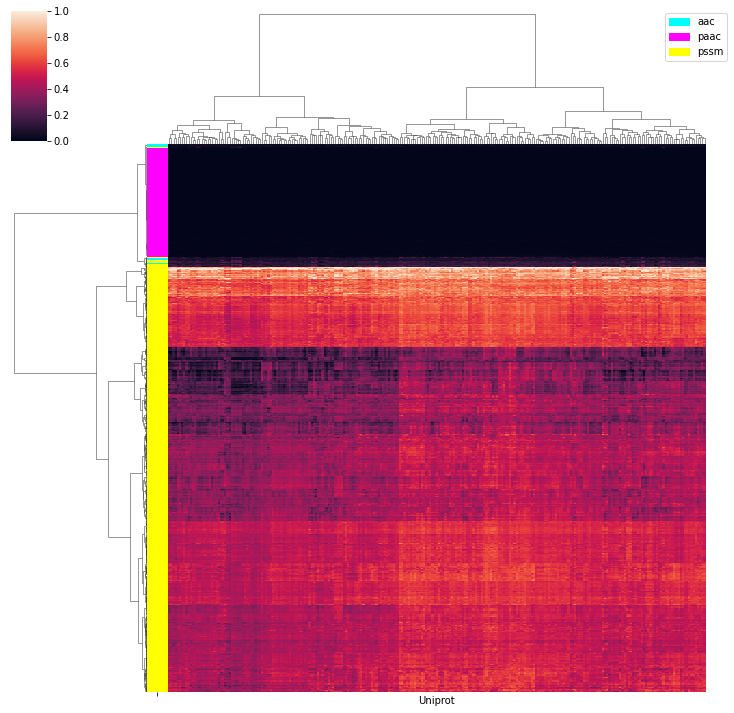

In [6]:
import re

aac = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY]$")
paac = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNPQRSTVWY]$")
pssm = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNPQRSTVWY]_\d\d_\d$")

def get_feature_type(feature_name):
    if paac.match(feature_name):
        return "paac"
    elif aac.match(feature_name):
        return "aac"
    elif pssm.match(feature_name):
        return "pssm"
    else:
        raise ValueError("unknown feature type!")

labeled_clustermap(df_combined.T, df_combined.columns.to_series().apply(get_feature_type))

PAAC and AAC values are a lot lower, since they are percentages, while PSSM values are scaled to [0,1]. The scaling was done along the feature axis, to avoid information sharing. What does the data look like when we also scale PAAC and AAC to [0,1]?

({'aac': 'cyan', 'paac': 'magenta', 'pssm': 'yellow'},
 <seaborn.matrix.ClusterGrid at 0x7fca1f4ae550>)

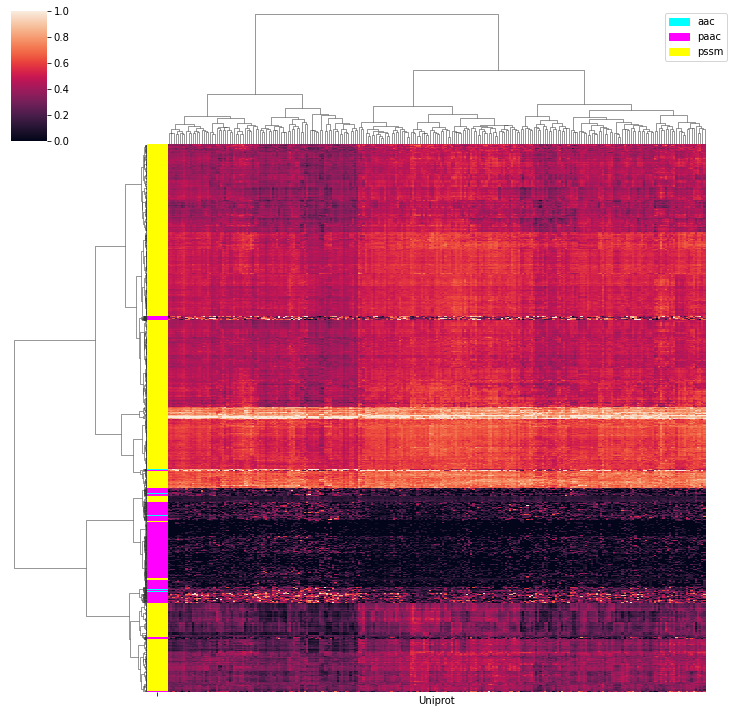

In [7]:
from sklearn.preprocessing import minmax_scale


def min_max_samples(df_feature):
    return pd.DataFrame(
        data=minmax_scale(df_feature, axis=1),
        index=df_feature.index,
        columns=df_feature.columns,
    )


df_combined_minmax = pd.concat(
    [min_max_samples(df_aac), min_max_samples(df_paac), min_max_samples(df_pssm)],
    axis=1,
)
# df_combined_minmax = pd.DataFrame(data=minmax_scale(df_combined, axis=1), index=df_combined.index, columns = df_combined.columns)
labeled_clustermap(
    df_combined_minmax.T, df_combined_minmax.columns.to_series().apply(get_feature_type)
)
# df_combined_minmax#.iloc[0].max()


There is a cluster with almost exclusively PSSM, and one cluster that is more mixed. The latter contains features with lower values.

The feature PCA plot looks similar to the other organisms and also shows the overlap:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

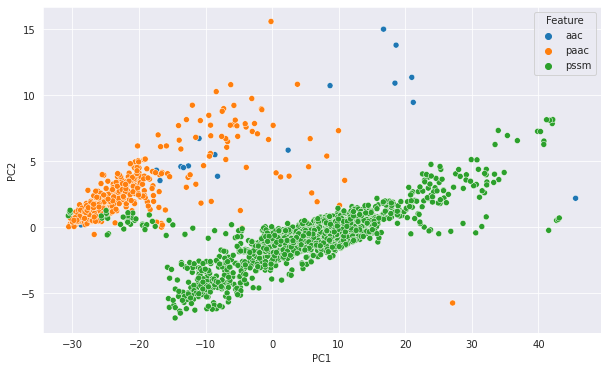

In [8]:
pca_plot_2d(df_combined_minmax.T, df_combined_minmax.T.index.to_series().apply(get_feature_type).rename("Feature"))

What does the data look like when standardizing along the feature axis? In the model, the parameters for this will be derived from the training set and applied to the test set, to avoid data leakage.

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fca017dc790>)

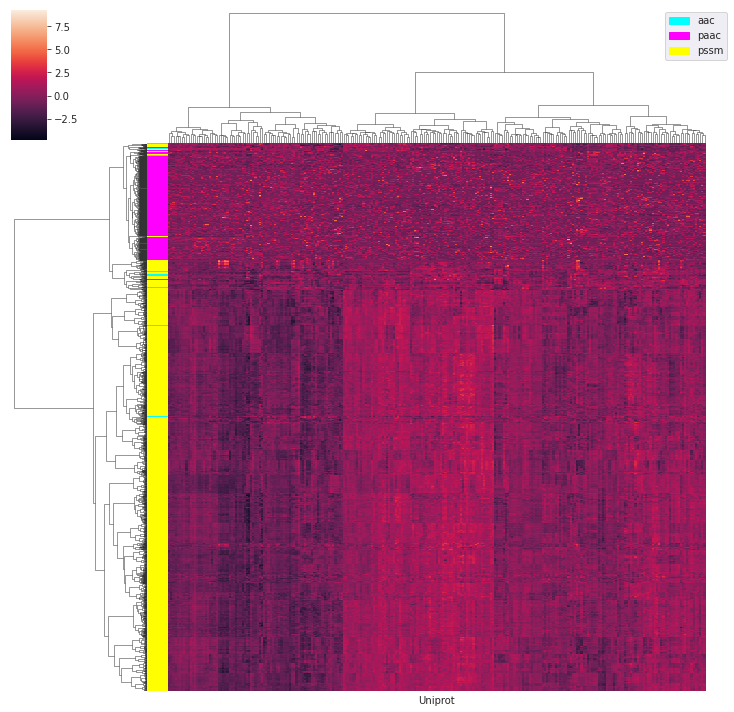

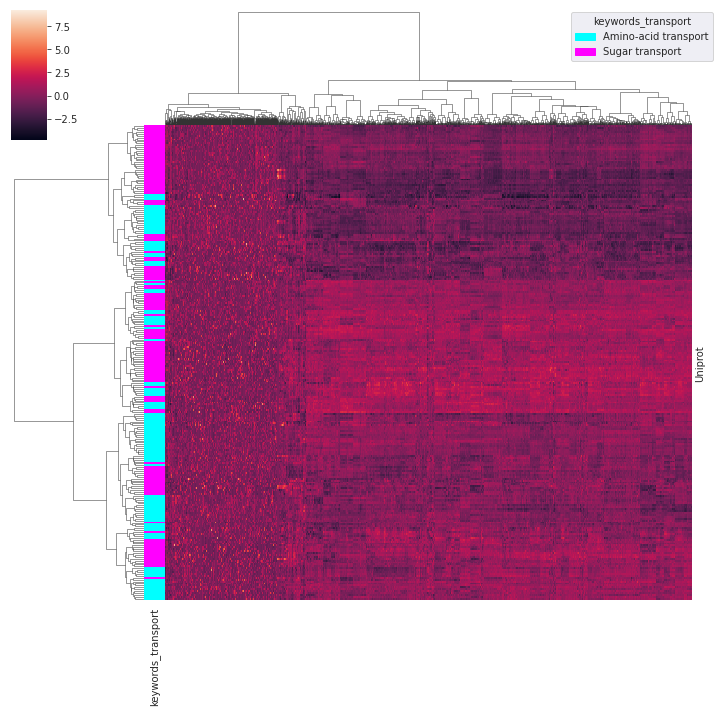

In [9]:
from sklearn.preprocessing import scale

df_combined_std = pd.DataFrame(
    data=scale(df_combined), index=df_combined.index, columns=df_combined.columns
)
labeled_clustermap(
    df_combined_std.T, df_combined.columns.to_series().apply(get_feature_type)
)
labeled_clustermap(
    df_combined_std, df.keywords_transport
)

The composition data looks a bit noisier, however this could also be caused by the fact that more PSSM features exist, and therefore have a higher impact on the h-clustering algorithm. The second plot shows that the two sample clusters do not correspond to the classes. 

There are two clusters, one for PSSM and one for the compositions. There are sub-clusters taht correspond to the substrates

The PCA plot of the standardized features also looks similar. There is a separation between most PSSM features and the rest of the dataset, possibly because of their lower variance

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

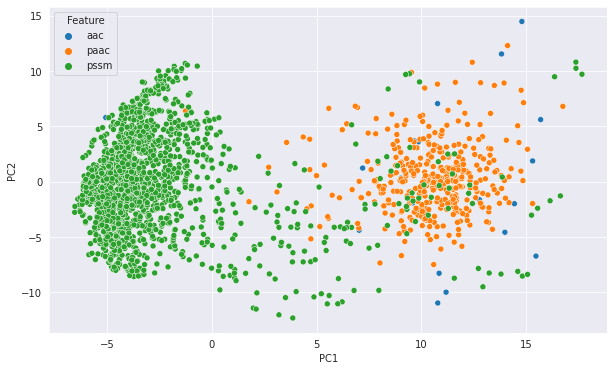

In [10]:
pca_plot_2d(df_combined_std.T, df_combined_std.T.index.to_series().apply(get_feature_type).rename("Feature"))

## Independent test set

In [6]:
X, y, feature_names, sample_names = preprocess_pandas(
    df_combined, labels, return_names=True
)
(
    X_train,
    X_test,
    y_train,
    y_test,
    sample_names_train,
    sample_names_test,
) = get_independent_test_set(X, y, sample_names=sample_names, test_size=0.2)

## Model comparison

In [12]:
models_quick_compare(X_train, y_train)

,0,1,2,3,4,mean,std
est,,,,,,,
GaussianNB(),0.925,0.650,0.775,0.670,0.718,0.748,0.110
KNeighborsClassifier(),0.749,0.850,0.795,0.899,0.769,0.812,0.061
"LinearSVC(class_weight='balanced', max_iter=1000000.0, random_state=0)",1.000,0.774,0.925,0.925,0.896,0.904,0.082
"LinearSVC(max_iter=1000000.0, random_state=0)",1.000,0.774,0.925,0.925,0.896,0.904,0.082
"RandomForestClassifier(class_weight='balanced', random_state=0)",0.875,0.673,0.795,0.824,0.791,0.792,0.074
RandomForestClassifier(random_state=0),0.925,0.775,0.847,0.798,0.869,0.843,0.059
SGDClassifier(random_state=0),0.975,0.725,0.900,0.949,0.820,0.874,0.102
"SVC(class_weight='balanced', random_state=0)",0.950,0.750,0.873,0.899,0.897,0.874,0.075
SVC(random_state=0),0.975,0.775,0.873,0.899,0.897,0.884,0.072


## Feature importance

How many top 50 features come from each feature type?

In [13]:
top50 = get_feature_score(df_combined, labels, remove_zero_variance=True).sort_values(
    "Normalized score", ascending=False
).head(50)
top50.Feature.apply(get_feature_type).value_counts()

pssm    35
paac    12
aac      3
Name: Feature, dtype: int64

The eukaryote-only dataset includes a lot more non-PSSM features in the top 50!

In [14]:
top50[top50.Feature.apply(get_feature_type) == "pssm"].head(10)

,Feature,Normalized score,Measure
1074,MP_50_3,0.009642,Feature importance (f_classif)
1474,MP_90_1,0.009064,Feature importance (f_classif)
1874,MP_90_3,0.008979,Feature importance (f_classif)
674,MP_50_1,0.008703,Feature importance (f_classif)
605,IQ_50_1,0.006386,Feature importance (f_classif)
1663,ND_90_3,0.005626,Feature importance (f_classif)
1263,ND_90_1,0.005197,Feature importance (f_classif)
1007,IG_50_3,0.004962,Feature importance (f_classif)
863,ND_50_3,0.004950,Feature importance (f_classif)
969,GI_50_3,0.004734,Feature importance (f_classif)


The most important features are again related to the exchange of Methionine for Proline.

In [15]:
top50[top50.Feature.apply(get_feature_type) == "pssm"].Feature.apply(lambda x: [x[0], x[1]]).explode().value_counts()

M    12
I    11
G     9
H     5
A     5
P     4
N     4
D     4
E     4
V     3
W     3
C     2
Y     2
Q     1
L     1
Name: Feature, dtype: int64

The most important amino acid wrt its conservation is Met this time  

## Parameter tuning

#### Custom transformer


All features, linear svm

In [16]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction=None,
    C=[0.01, 0.1, 1, 10],
)

{'linearsvc__C': 10, 'linearsvc__class_weight': 'balanced', 'linearsvc__dual': False, 'linearsvc__max_iter': 100000000.0}
0.909


The PSSMselector selects PSSMs made with Uniref50

In [17]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction=None,
    C=[0.01, 0.1, 1, 10],
    feature_transformer="pssm",
    feature_names=feature_names,
)

{'linearsvc__C': 10, 'linearsvc__class_weight': None, 'linearsvc__dual': False, 'linearsvc__max_iter': 100000000.0, 'pssmselector__iterations': 'all', 'pssmselector__uniref_threshold': 50}
0.914


RBF improves the results:

In [18]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction=None,
    C=[0.1, 1, 10],
)

{'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.913


Removing PSSMs with one iteration leads to a slight improvement:

In [19]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction=None,
    C=[0.1, 1, 10, 100],
    feature_transformer="pssm",
    feature_names=feature_names,
)
best_estimator_svc = gsearch

{'pssmselector__iterations': 3, 'pssmselector__uniref_threshold': 'all', 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.919


## Dimensionality reduction

Trying only in steps of 20, to reduce runtime.

In [8]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="kbest",
    C=[0.1, 1, 10, 100],
    select_k_steps=20,
    remove_zero_var=True,
)
best_estimator_svc_kbest = gsearch

{'selectkbest__k': 1341, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.918


In [21]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="pca",
    # feature_transformer="pssm",
    # feature_names=feature_names,
    # C=[0.1, 0.01, 0.001],
    # gamma=[0.1, 0.01, 0.001],
)


{'pca__n_components': 0.97, 'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.924


Does using the pssm selector change anything?

In [22]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="pca",
    feature_transformer="pssm",
    feature_names=feature_names,
    # C=[0.1, 0.01, 0.001],
    # gamma=[0.1, 0.01, 0.001],
)

best_estimator_svc_pca = gsearch

{'pca__n_components': 0.97, 'pssmselector__iterations': 'all', 'pssmselector__uniref_threshold': 'all', 'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.924


## Validation



#### PCA

In [23]:
get_confusion_matrix(X_test, y_test, best_estimator_svc_pca, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,19,4
Sugar transport,2,25


In [24]:
get_classification_report(X_test, y_test, best_estimator_svc_pca, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,0.905,0.826,0.864,23
Sugar transport,0.862,0.926,0.893,27
macro avg,0.883,0.876,0.878,50
weighted avg,0.882,0.880,0.879,50


#### All features


In [25]:
get_confusion_matrix(X_test, y_test, best_estimator_svc, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,19,4
Sugar transport,2,25


In [26]:
get_classification_report(X_test, y_test, best_estimator_svc, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,0.905,0.826,0.864,23
Sugar transport,0.862,0.926,0.893,27
macro avg,0.883,0.876,0.878,50
weighted avg,0.882,0.880,0.879,50


#### Kbest

In [9]:
get_confusion_matrix(X_test, y_test, best_estimator_svc_kbest, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,20,3
Sugar transport,2,25


In [10]:
get_classification_report(X_test, y_test, best_estimator_svc_kbest, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,0.909,0.870,0.889,23
Sugar transport,0.893,0.926,0.909,27
macro avg,0.901,0.898,0.899,50
weighted avg,0.900,0.900,0.900,50


## Estimating validation variance

How much did the result depend on choosing the training and test sets?

Mean and standard deviation for randomly selected training and validation sets.

In [27]:
df_scores, df_params = full_test(
    df_combined,
    labels,
    dim_reduction="pca",
    kernel="rbf",
    repetitions=10,
    feature_transformer="pssm",
)
df_scores_gr = df_scores.groupby(["label", "dataset"], as_index=False)
print("Mean F1")
display(df_scores_gr.mean().pivot(index="label", columns="dataset", values="F1 score"))
print("Sdev F1")
display(df_scores_gr.std().pivot(index="label", columns="dataset", values="F1 score"))
print("Parameters")
display(df_params)

Mean F1


dataset,test,train
label,,
Amino-acid transport,0.8993,0.9327
Sugar transport,0.9178,0.9436


Sdev F1


dataset,test,train
label,,
Amino-acid transport,0.056907,0.013090
Sugar transport,0.039254,0.009686


Parameters


,0,1,2,3,4,5,6,7,8,9
pca__n_components,0.88,0.82,0.96,0.97,0.97,0.97,0.98,0.99,0.98,0.91
pssmselector__iterations,all,all,all,1,all,all,3,1,1,all
pssmselector__uniref_threshold,all,50,50,all,all,50,50,all,all,all
svc__C,10,10,1,10,10,10,1,10,10,10
svc__class_weight,balanced,None,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__gamma,scale,0.01,scale,scale,scale,0.01,0.01,scale,0.01,scale


The eukaryotes-dataset again shows a slightly higher average F1 score, but not by much.